In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requir

In [ ]:
import numpy as np
from sklearn import preprocessing
import pandas as pd
from sklearn.preprocessing import normalize
from keras.layers import Input, Conv2D,  Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from itertools import permutations
from keras.layers import LSTM, Permute,Reshape
import keras
import tensorflow as tf
from keras.models import model_from_json
from keras.constraints import max_norm
import collections
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import seaborn as sn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import matplotlib.cm as cm

from itertools import permutations, combinations, combinations_with_replacement
import gc
from tqdm import tqdm
import glob

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine.base_layer import Layer
# from tensorflow.python.keras.utils import control_flow_util
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.util.tf_export import keras_export
import os

Using TensorFlow backend.


In [ ]:
# os.listdir('.')

NUM_CLASSES = 4

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 60

# Hardcoded step of the sliding window mechanism employed to segment the data
# SLIDING_WINDOW_STEP = 160

NUM_CHANNEL = 9

In [ ]:
def load_tensor(path, sensor):
    # Read the array from disk
    #new_data = np.loadtxt('./ActiveData/Sub'+str(name)+'_data.txt')
    new_data = np.loadtxt(path)
    
    #changing NUM_CHANNEL according to sensor combination type
    combination = ['WT', 'AW']
    single = ['A', 'W', 'T']
    if sensor in combination:
        NUM_CHANNEL = 6
    elif sensor in single:
        NUM_CHANNEL = 3
    else:
        NUM_CHANNEL = 9

    # Note that this returned a 2D array!
    # print(new_data.shape)
    
    # However, going back to 3D is easy if we know the 
    # original shape of the array
    if sensor == "All":
        pass
    elif sensor == "WT":
        new_data = new_data[:,:6]
    elif sensor == "AW":
        new_data = new_data[:,3:]
    elif sensor == 'A':
        new_data = new_data[:,6:]
    elif sensor == 'W':
        new_data = new_data[:,3:6]
    elif sensor == 'T':
        new_data = new_data[:,:3]

    new_data = new_data.reshape((-1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL))

    return new_data, NUM_CHANNEL

In [ ]:
def load_by_subject(id, arg, trial_id, sensor):
    x_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/Sub'+str(id)+'_'+arg+'_data.txt'
    y_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/data/trial'+str(trial_id)+'/Sub'+str(id)+'_'+arg+'_label.txt'
    x_data, _ = load_tensor(x_path, sensor)
    y_data = np.loadtxt(y_path)
    idx = np.where(y_data==4)
    y_data[idx] = 3 

    return x_data, y_data

In [ ]:
def eval_perf(ground_truth, predicted_event):
    print('Accuracy score is: ')
    acc = accuracy_score(ground_truth, predicted_event)
    print(acc)
    print('Confusion Matrix is:')
    my_matrix = confusion_matrix(ground_truth, predicted_event)
    my_matrix_n = normalize(my_matrix, axis=1,norm = 'l1')
    print(pd.DataFrame(my_matrix_n).applymap(lambda x: '{:.2%}'.format(x)).values)

    #target_names = ['Walking','Jogging','Stairs','Sitting','Standing']
    target_names = ['Lying', 'Sitting', 'Standing', 'Walking']
    df_cm = pd.DataFrame(my_matrix_n, index = [i for i in target_names],
                  columns = [i for i in target_names])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    print(classification_report(ground_truth, predicted_event, target_names=target_names))  
    return acc

In [ ]:
def convert_list(my_list):
    length = len(my_list)
    if length==0:
        return
    res = my_list[0]
    for i in range(1,length):
        res = np.vstack((res,my_list[i]))
    return res

def convert_y(my_list):
    length = len(my_list)
    if length==0:
        return
    res = my_list[0]
    for i in range(1,length):
        res = np.concatenate((res,my_list[i]))
    return res

In [ ]:
labels = np.array([0,1,2,3])
lb = preprocessing.LabelBinarizer()
lb.fit(y=labels)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
def randomly_sample(X,y,num):
    resx, resy = [],[]
    for i in range(len(labels)):
        list0 = np.where(y==labels[i])
        ind0 = random.choice (list0)[:num]
        resy.append(y[ind0].reshape(-1,1))
        resx.append(X[ind0])
        X = np.delete(X,ind0,0)
        y = np.delete(y,ind0,0)
    X_train = convert_list(resx)
    y_train = convert_list(resy)
    return X_train,y_train,X,y

#selectively replace certain activity from training samples, eg: jump,run，lying=6,7,10
# def reduce_data(x,y,aid):
#     ind = np.where(y==aid)
#     y = np.delete(y,ind)
#     x = np.delete(x,ind,axis=0)
#     return x,y

# def select_act(x,y,aid):
#     ind = np.where(y==aid)
#     res = x[ind,:,:]
#     return res.reshape(-1,200,6),y[ind]

#X2,y2 = load_data_by_id(2)
#d1,dy1 = select_act(X2,y2,6)
#d2,dy2 = select_act(X2,y2,7)
#X = np.vstack((d1,d2))
#y = np.concatenate((dy1,dy2))
#selectively remove certain activity from training samples, eg: jog,outbed,squat=5,6,7
# def partial_reduce_data(x,y,aid,num):
#     ind = np.where(y==aid)
#     #t = ind.shape[0]
#     y = np.delete(y,ind[0][:int(10-num)])
#     x = np.delete(x,ind[0][:int(10-num)],axis=0)
#     return x,y

def load_data_num(num):
    #1649 is good
    X1,y1 = load_by_subject('20', 'train', 1, 'All')
    X2,y2 = load_by_subject('20', 'train', 2, 'All')

    X, y = np.vstack((X1,X2)), np.concatenate((y1,y2))


    Xtest1, ytest1 = load_by_subject('20', 'test', 1, 'All')
    Xtest2, ytest2 = load_by_subject('20', 'test', 2, 'All')

    Xtest, ytest = np.vstack((Xtest1,Xtest2)), np.concatenate((ytest1,ytest2))
    #fix 100 per class as test
    # X,Xtest,y,ytest = train_test_split(X,y,test_size=1100,stratify=y,
                                                    #    random_state=42)
    #remove jump and run from sub1
    # X,y = partial_reduce_data(X,y,10,n)
    # X,y = partial_reduce_data(X,y,6,n)
    # #replace jump and run with sub2
    # X2,y2 = load_data_by_id(5)
    # d1,dy1 = select_act(X2,y2,10)
    # d2,dy2 = select_act(X2,y2,6)
    # X = np.vstack((X,d1[:n,:,:]))
    # X = np.vstack((X,d2[:n,:,:]))
    # y = np.concatenate((y,dy1[:n]))
    # y = np.concatenate((y,dy2[:n]))
    #not required for our model
    
    X_train,y_train,Xval,yval = randomly_sample(X,y,num)
    ytrain = y_train.reshape(-1,)
    print(collections.Counter(ytrain))
    return X_train,y_train,Xval,Xtest,yval,ytest

###Attention Base Class

In [ ]:
class BaseDenseAttention(keras.layers.Layer):
  def __init__(self, causal=False, dropout=0.0,
               **kwargs):
    super(BaseDenseAttention, self).__init__(**kwargs)
    self.causal = causal
    self.dropout = dropout
    self.supports_masking = True

  def _calculate_scores(self, query, key):
    return NotImplementedError

  def _apply_scores(self, scores, value, scores_mask=None, training=None):
    if scores_mask is not None:
      padding_mask = math_ops.logical_not(scores_mask)
      # Bias so padding positions do not contribute to attention distribution.
      # Note 65504. is the max float16 value.
      if scores.dtype is dtypes.float16:
        scores -= 65504. * math_ops.cast(padding_mask, dtype=scores.dtype)
      else:
        scores -= 1.e9 * math_ops.cast(padding_mask, dtype=scores.dtype)
    if training is None:
      training = backend.learning_phase()
    weights = nn.softmax(scores)

    def dropped_weights():
      return nn.dropout(weights, rate=self.dropout)

    # weights = control_flow_util.smart_cond(training, dropped_weights,
    #                                        lambda: array_ops.identity(weights))
    return math_ops.matmul(weights, value), weights

  # TODO(b/125916026): Consider exposing a __call__ method with named args.
  def call(self,
           inputs,
           mask=None,
           training=None,
           return_attention_scores=False):
    self._validate_call_args(inputs=inputs, mask=mask)
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v
    q_mask = mask[0] if mask else None
    v_mask = mask[1] if mask else None
    scores = self._calculate_scores(query=q, key=k)
    if v_mask is not None:
      # Mask of shape [batch_size, 1, Tv].
      v_mask = array_ops.expand_dims(v_mask, axis=-2)
    if self.causal:
      # Creates a lower triangular mask, so position i cannot attend to
      # positions j>i. This prevents the flow of information from the future
      # into the past.
      scores_shape = array_ops.shape(scores)
      # causal_mask_shape = [1, Tq, Tv].
      causal_mask_shape = array_ops.concat(
          [array_ops.ones_like(scores_shape[:-2]), scores_shape[-2:]],
          axis=0)
      causal_mask = _lower_triangular_mask(causal_mask_shape)
    else:
      causal_mask = None
    # scores_mask = _merge_masks(v_mask, causal_mask)
    result, attention_scores = self._apply_scores(
        scores=scores, value=v, training=training) #scores_mask=scores_mask
    if q_mask is not None:
      # Mask of shape [batch_size, Tq, 1].
      q_mask = array_ops.expand_dims(q_mask, axis=-1)
      result *= math_ops.cast(q_mask, dtype=result.dtype)
    if return_attention_scores:
      return result, attention_scores
    return result

  def compute_mask(self, inputs, mask=None):
    self._validate_call_args(inputs=inputs, mask=mask)
    if mask:
      q_mask = mask[0]
      if q_mask is None:
        return None
      return ops.convert_to_tensor_v2_with_dispatch(q_mask)
    return None

  def _validate_call_args(self, inputs, mask):
    """Validates arguments of the call method."""
    class_name = self.__class__.__name__
    if not isinstance(inputs, list):
      raise ValueError(
          '{} layer must be called on a list of inputs, namely [query, value] '
          'or [query, value, key].'.format(class_name))
    if len(inputs) < 2 or len(inputs) > 3:
      raise ValueError(
          '{} layer accepts inputs list of length 2 or 3, '
          'namely [query, value] or [query, value, key]. '
          'Given length: {}'.format(class_name, len(inputs)))
    if mask:
      if not isinstance(mask, list):
        raise ValueError(
            '{} layer mask must be a list, '
            'namely [query_mask, value_mask].'.format(class_name))
      if len(mask) < 2 or len(mask) > len(inputs):
        raise ValueError(
            '{} layer mask must be a list of length 2, namely [query_mask, '
            'value_mask]. Given length: {}'.format(class_name, len(mask)))

  def get_config(self):
    config = {
        'causal': self.causal,
        'dropout': self.dropout,
    }
    base_config = super(BaseDenseAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


# @keras_export('keras.layers.Attention')
class Attention(BaseDenseAttention):
  def __init__(self, use_scale=False, **kwargs):
    super(Attention, self).__init__(**kwargs)
    self.use_scale = use_scale

  def build(self, input_shape):
    """Creates scale variable if use_scale==True."""
    if self.use_scale:
      self.scale = self.add_weight(
          name='scale',
          shape=(),
          initializer=init_ops.ones_initializer(),
          dtype=self.dtype,
          trainable=True)
    else:
      self.scale = None
    super(Attention, self).build(input_shape)

  def _calculate_scores(self, query, key):
    scores = math_ops.matmul(query, key, transpose_b=True)
    if self.scale is not None:
      scores *= self.scale
    return scores

  def get_config(self):
    config = {'use_scale': self.use_scale}
    base_config = super(Attention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

###Defining Models

In [ ]:
def load_tmtl(model_type = 'base'):

    flag = 0

    if model_type == 'base':
        json_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_modelusfinalall.json'
        weights_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_weightsusfinalall.h5'
    elif model_type == 'attention':
        json_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_model_usall_new_rest.json'
        weights_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_model_usall_new_rest.h5'
        flag=1
    elif model_type == 'attention_dense':
        json_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_model_usall_attention_dense.json'  
        weights_path = '/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Final/trimtl_model_usall_attention_dense.h5'  
        flag=1

    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    if flag==1:
        model = model_from_json(loaded_model_json, custom_objects={'Attention': Attention})
    else:
        model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(weights_path)
    print("Loaded model from disk")
    # print(model.summary())
    return model

In [ ]:
def create_base_network():
    multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
    print(multi_input.shape)  # (?, 1, 24, 113)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format='channels_first')(multi_input)
    print(y.shape)  # (?, 64, 20, 113)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format='channels_first')(y)
    print(y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format='channels_first')(y)
    print(y.shape)
    y = Conv2D(64, (5, 1), activation='relu', data_format='channels_first')(y)
    print(y.shape)
    
    y = Permute((2, 1, 3))(y)
    print(y.shape)  # (?, 20, 64, 113)
    
    # This line is what you missed
    # ==================================================================
    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)

    # ==================================================================
    print(y.shape)  # (?, 20, 7232)
    
    y = LSTM(128,dropout=0.25,return_sequences=True)(y)
    y = LSTM(128)(y)
      # (?, 128)
    y = Dense(NUM_CLASSES,activation = 'softmax')(y)
    print(y.shape)
    return keras.Model(inputs=multi_input, outputs=y)  

In [ ]:
def Conv_Att_LSTM(attention = "Luong", dropout = 0.2):  #specify type of attention as a param

    multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
    format = 'channels_first'

    if attention == "Luong":
        attention1 = Attention(dropout = dropout)
        attention2 = Attention(dropout = dropout)
    # elif attention == 'MultiHead':
    #     attention1 = MultiHeadAttention(num_heads=4)
    #     attention2 = MultiHeadAttention(num_heads=4)
    
    # print("Input: ", multi_input.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(multi_input)
    # print("1: ", y.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("2: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("3: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("4: ", y.shape)

    y = Permute((2, 1, 3))(y)
    # print("5: ", y.shape)

    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)
    # print("6: ", y.shape)

    #adding attention layer, type of attention specified above

    y = attention1([y,y]) #attention layer - more like self attention but used along with conv and lstm

    # print("Between", y.shape)
    
    y = LSTM(128,dropout=0.25,return_sequences=True)(y)

    # print("7: ", y.shape)

    y = attention2([y,y])

    y = LSTM(128)(y)

    y = Dense(4, activation = 'softmax')(y)

    # y = attention([y,y])

    # print("8: ", y.shape)
    
    # print("9: ", y.shape)
    return Model(inputs=multi_input, outputs=y) 

In [ ]:
def Conv_Att_LSTM_Dense(attention = "Luong", dropout = 0.2):  #specify type of attention as a param

    multi_input = Input(shape=(1, SLIDING_WINDOW_LENGTH, NUM_CHANNEL), name='multi_input')
    format = 'channels_first'

    if attention == "Luong":
        attention1 = Attention(dropout = dropout)
        attention2 = Attention(dropout = dropout)
    # elif attention == 'MultiHead':
    #     attention1 = MultiHeadAttention(num_heads=4)
    #     attention2 = MultiHeadAttention(num_heads=4)
    
    # print("Input: ", multi_input.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(multi_input)
    # print("1: ", y.shape)
    
    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("2: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("3: ", y.shape)

    y = Conv2D(64, (5, 1), activation='relu', data_format=format)(y)
    # print("4: ", y.shape)

    y = Permute((2, 1, 3))(y)
    # print("5: ", y.shape)

    y = Reshape((int(y.shape[1]), int(y.shape[2]) * int(y.shape[3])))(y)
    # print("6: ", y.shape)

    #adding attention layer, type of attention specified above

    query_encoding1 = Dense(300, activation='relu')(y)
    value_encoding1 = Dense(300, activation='relu')(y)


    y = attention1([query_encoding1,value_encoding1]) #attention layer - more like self attention but used along with conv and lstm

    # print("Between", y.shape)
    
    y = LSTM(128,dropout=0.25,return_sequences=True)(y)

    # print("7: ", y.shape)

    query_encoding2 = Dense(int(y.shape[2]), activation='relu')(y)
    value_encoding2 = Dense(int(y.shape[2]), activation='relu')(y)

    y = attention2([query_encoding2,value_encoding2])

    y = LSTM(128)(y)

    y = Dense(4, activation = 'softmax')(y)

    # y = attention([y,y])

    # print("8: ", y.shape)
    
    # print("9: ", y.shape)
    return Model(inputs=multi_input, outputs=y)

In [ ]:
def network_test(model_type='base'):
    if model_type=='base':
        model = create_base_network()
    elif model_type == 'attention':
        model = Conv_Att_LSTM(attention='Luong')
    elif model_type == 'attention_dense':
        model = Conv_Att_LSTM_Dense(attention='Luong')

    return model

In [ ]:
def duplicate(data):
    res=[]
    res.append(data.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL))
    res.append(data.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL))
    res.append(data.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL))
    return res

In [ ]:
def evaluate_tmtl(X_train,y_train,Xval,Xtest,yval,ytest, model_type):
    model = load_tmtl(model_type=model_type)
    
    #filter out data that no need for fast adaptation
    #Xtrain,ytrain = reduce_data(Xtrain,ytrain,6)
    #Xtrain,ytrain = partial_reduce_data(Xtrain,ytrain,5, 0.8)
    #Xtrain,ytrain = reduce_data(Xtrain,ytrain,8)
    #y_ = lb.transform(ytrain)
    
    xtrain_ = duplicate(X_train)
    val_ = duplicate(Xval)
    ytrain = y_train.reshape(-1,)
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer('merged_layer').output)
    intermediate_output_ = intermediate_layer_model.predict(xtrain_)
    xval_ = intermediate_layer_model.predict(val_)
    y_ = lb.transform(ytrain)
    yval_ = lb.transform(yval)
    xtest_ = duplicate(Xtest.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL))
    test = intermediate_layer_model.predict(xtest_)
…        #with tf.device('/gpu:0'): 
        Classifier_model.fit(intermediate_output_,y_,callbacks=[es,mc],verbose=0,
                                 validation_data=(xval_,yval_),shuffle=True,epochs=3000)
        
        
        myy = Classifier_model.predict(test)
        predict_class = lb.inverse_transform(myy)
        tmp = eval_perf(ytest,predict_class)
        acc1.append(tmp)
    return acc1,np.asarray(acc1).max() intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer('merged_layer').output)
    intermediate_output_ = intermediate_layer_model.predict(xtrain_)
    xval_ = intermediate_layer_model.predict(val_)
    y_ = lb.transform(ytrain)
    yval_ = lb.transform(yval)
    xtest_ = duplicate(Xtest.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL))
    test = intermediate_layer_model.predict(xtest_)
    
    es = EarlyStopping(monitor='val_accuracy', mode='auto',patience=200,verbose=2)
    mc = ModelCheckpoint('/content/drive/MyDrive/MITACS_Nithin/juravinski/T-MTL_Models/Evaluation/best_classifier_'+model_type+'.h5', monitor='val_accuracy',mode='max',save_best_only=True)
    
    acc1 = []
    #7 seen subjects in tmtl(5,18)
    for i in range(5,7):
        W1 = model.layers[i].get_weights()
        #to define initial weights, have to pass a function
        def init_S_(shape, dtype=None):
            ker = np.zeros(shape, dtype=dtype)
            ker = W1[0]
            return ker
        
        Classifier_input = Input((384,))
        Classifier_output = Dense(4, 
                                  kernel_initializer=init_S_,
                                  activation='softmax')(Classifier_input)
        Classifier_model = Model(Classifier_input, Classifier_output)
        Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        #with tf.device('/gpu:0'): 
        Classifier_model.fit(intermediate_output_,y_,callbacks=[es,mc],verbose=0,
                                 validation_data=(xval_,yval_),shuffle=True,epochs=3000)
        
        
        myy = Classifier_model.predict(test)
        predict_class = lb.inverse_transform(myy)
        tmp = eval_perf(ytest,predict_class)
        acc1.append(tmp)
    return acc1,np.asarray(acc1).max()

In [ ]:
def evaluate_stl(X_train,y_train,Xval,X_test,yval,y_test, model_type):
    X_train = X_train.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL) 
    m = network_test(model_type)
    #m.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # print(m.summary())
    res = lb.transform(y_train)
    n_epoch = 100
    #train with gpu
    #with tf.device('/gpu:0'):
    train_history = m.fit(X_train,res,epochs=n_epoch,
                          batch_size=100,verbose=0,shuffle=True)
    
    import time
    #predict label
    X_test = X_test.reshape(-1,1,SLIDING_WINDOW_LENGTH,NUM_CHANNEL)
    #count the predict time
    start_time = time.time()
    predict_y = m.predict(X_test)
    print("Run in --- %s seconds ---" % (time.time() - start_time))
    predict_class = lb.inverse_transform(predict_y)
    
    #evaluate and print predict result
    acc3 = eval_perf(y_test,predict_class)
    return acc3

In [ ]:
acc1_,a1_, acc2_ = [],[],[]
model_type = 'base'

for times in tqdm(range(2,11,2)):
    X_train,y_train,Xval,Xtest,yval,ytest = load_data_num(times)
    # acc1,a1 = evaluate_bmtl(X_train,y_train,Xval,Xtest,yval,ytest)
    acc1,a1 = evaluate_tmtl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc2 = evaluate_stl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc1_.append(acc1)
    a1_.append(a1)
    acc2_.append(acc2)
    # a2_.append(a2)
    # acc3_.append(acc3)
    # i+=3
print("Accuracy of Best Classifiers: Base Model", a1_)
print("Accuracy of Both Classifiers: Base Model",acc1_)
# print(a2_)
print("Accuracy of Single Task Model",acc2_)


  0%|          | 0/5 [00:00<?, ?it/s]

Counter({0.0: 2, 1.0: 2, 2.0: 2, 3.0: 2})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.9295499021526419
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.67%' '1.00%' '0.00%']
 ['0.67%' '6.00%' '92.33%' '1.00%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
              precision    recall  f1-score   support

       Lying       0.87      1.00      0.93       300
     Sitting       0.93      0.86      0.89       300
    Standing       0.98      0.92      0.95       300
     Walking       0.97      0.95      0.96       122

    accuracy                           0.93      1022
   macro avg       0.94      0.93      0.93      1022
weighted avg       0.93      0.93      0.93      1022

Epoch 00201: early stopping
Accuracy score is: 
0.9285714285714286
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.33%' '1.33%' '0.00%']
 ['0.67%' '6.00%' '92.33%' '1.00%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
              precision    rec


 20%|██        | 1/5 [03:27<13:50, 207.55s/it]

Run in --- 5.892822027206421 seconds ---
Accuracy score is: 
0.8718199608610567
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['15.67%' '84.33%' '0.00%' '0.00%']
 ['0.00%' '14.00%' '81.67%' '4.33%']
 ['0.00%' '7.38%' '16.39%' '76.23%']]
              precision    recall  f1-score   support

       Lying       0.86      1.00      0.93       300
     Sitting       0.83      0.84      0.84       300
    Standing       0.92      0.82      0.87       300
     Walking       0.88      0.76      0.82       122

    accuracy                           0.87      1022
   macro avg       0.87      0.86      0.86      1022
weighted avg       0.87      0.87      0.87      1022

Counter({0.0: 4, 1.0: 4, 2.0: 4, 3.0: 4})
Loaded model from disk
Epoch 00373: early stopping
Accuracy score is: 
0.9285714285714286
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.67%' '1.00%' '0.00%']
 ['0.67%' '6.00%' '92.00%' '1.33%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
              p


 40%|████      | 2/5 [08:47<12:03, 241.25s/it]

Run in --- 6.220583200454712 seconds ---
Accuracy score is: 
0.6585127201565558
Confusion Matrix is:
[['76.67%' '0.00%' '0.00%' '23.33%']
 ['23.00%' '65.33%' '10.67%' '1.00%']
 ['3.00%' '7.33%' '52.33%' '37.33%']
 ['0.00%' '9.84%' '16.39%' '73.77%']]
              precision    recall  f1-score   support

       Lying       0.75      0.77      0.76       300
     Sitting       0.85      0.65      0.74       300
    Standing       0.75      0.52      0.62       300
     Walking       0.33      0.74      0.45       122

    accuracy                           0.66      1022
   macro avg       0.67      0.67      0.64      1022
weighted avg       0.73      0.66      0.67      1022

Counter({0.0: 6, 1.0: 6, 2.0: 6, 3.0: 6})
Loaded model from disk
Epoch 00245: early stopping
Accuracy score is: 
0.9285714285714286
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.67%' '1.00%' '0.00%']
 ['0.67%' '6.00%' '92.00%' '1.33%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
              


 60%|██████    | 3/5 [14:15<08:54, 267.31s/it]

Run in --- 6.429905652999878 seconds ---
Accuracy score is: 
0.8532289628180039
Confusion Matrix is:
[['99.33%' '0.67%' '0.00%' '0.00%']
 ['13.67%' '81.33%' '5.00%' '0.00%']
 ['0.00%' '12.67%' '78.33%' '9.00%']
 ['0.00%' '5.74%' '16.39%' '77.87%']]
              precision    recall  f1-score   support

       Lying       0.88      0.99      0.93       300
     Sitting       0.84      0.81      0.83       300
    Standing       0.87      0.78      0.82       300
     Walking       0.78      0.78      0.78       122

    accuracy                           0.85      1022
   macro avg       0.84      0.84      0.84      1022
weighted avg       0.85      0.85      0.85      1022

Counter({0.0: 8, 1.0: 8, 2.0: 8, 3.0: 8})
Loaded model from disk
Epoch 00283: early stopping
Accuracy score is: 
0.9285714285714286
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.67%' '1.00%' '0.00%']
 ['0.67%' '6.00%' '92.00%' '1.33%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
              pr


 80%|████████  | 4/5 [19:34<04:42, 282.82s/it]

Run in --- 6.719999313354492 seconds ---
Accuracy score is: 
0.6350293542074364
Confusion Matrix is:
[['52.33%' '0.33%' '0.00%' '47.33%']
 ['1.67%' '64.33%' '11.00%' '23.00%']
 ['0.00%' '9.33%' '66.00%' '24.67%']
 ['0.00%' '2.46%' '14.75%' '82.79%']]
              precision    recall  f1-score   support

       Lying       0.97      0.52      0.68       300
     Sitting       0.86      0.64      0.74       300
    Standing       0.80      0.66      0.72       300
     Walking       0.26      0.83      0.40       122

    accuracy                           0.64      1022
   macro avg       0.72      0.66      0.63      1022
weighted avg       0.80      0.64      0.67      1022

Counter({0.0: 10, 1.0: 10, 2.0: 10, 3.0: 10})
Loaded model from disk
Epoch 00261: early stopping
Accuracy score is: 
0.9275929549902152
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['13.33%' '85.67%' '1.00%' '0.00%']
 ['0.67%' '6.33%' '91.67%' '1.33%']
 ['0.82%' '0.82%' '3.28%' '95.08%']]
          


100%|██████████| 5/5 [26:23<00:00, 316.74s/it]

Run in --- 6.977400064468384 seconds ---
Accuracy score is: 
0.850293542074364
Confusion Matrix is:
[['96.67%' '2.33%' '0.00%' '1.00%']
 ['11.67%' '84.67%' '3.33%' '0.33%']
 ['0.00%' '11.67%' '82.00%' '6.33%']
 ['0.00%' '16.39%' '18.85%' '64.75%']]
              precision    recall  f1-score   support

       Lying       0.89      0.97      0.93       300
     Sitting       0.80      0.85      0.82       300
    Standing       0.88      0.82      0.85       300
     Walking       0.77      0.65      0.71       122

    accuracy                           0.85      1022
   macro avg       0.84      0.82      0.83      1022
weighted avg       0.85      0.85      0.85      1022

Accuracy of Best Classifiers: Attention Model [0.9295499021526419, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.9275929549902152]
Accuracy of Both Classifiers:Attention Model [[0.9295499021526419, 0.9285714285714286], [0.9285714285714286, 0.9275929549902152], [0.9285714285714286, 0.9275929549902152

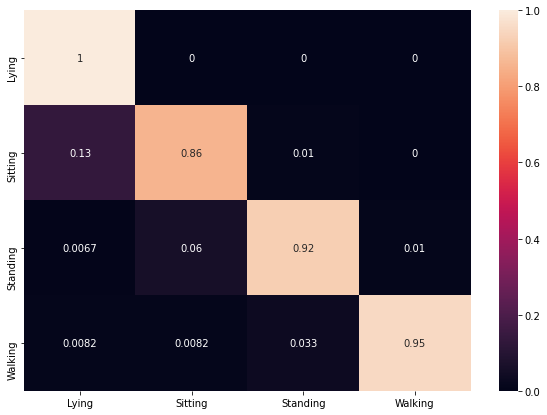

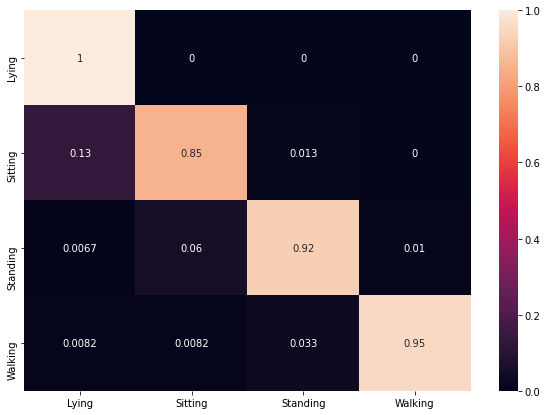

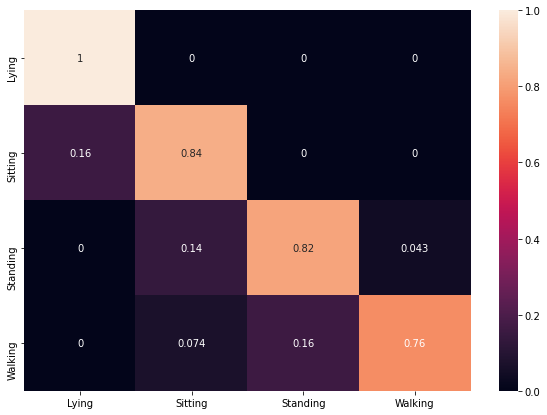

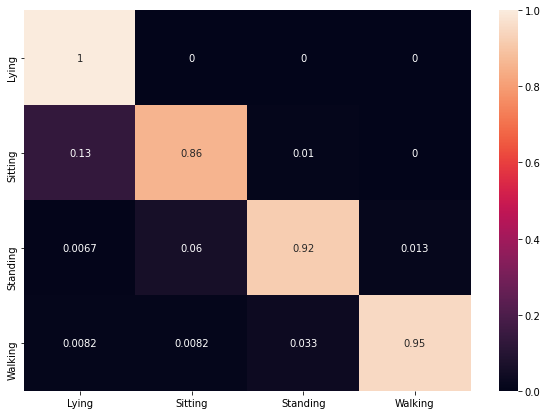

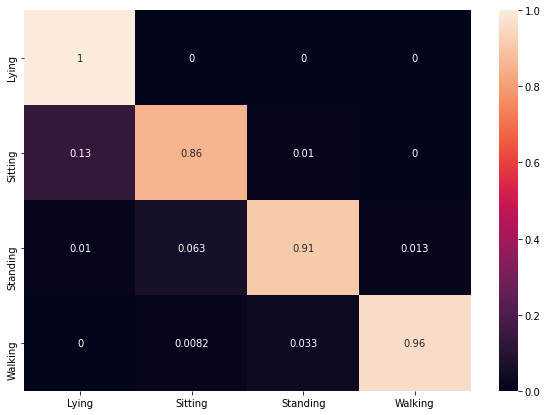

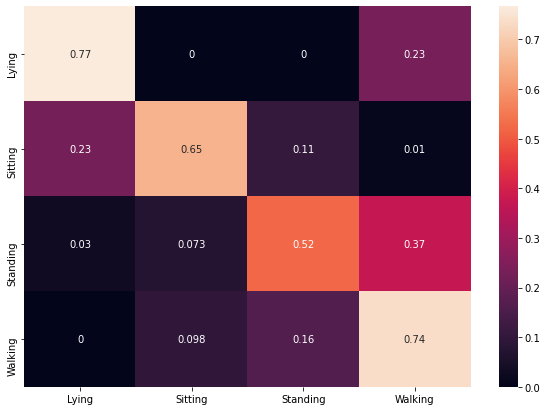

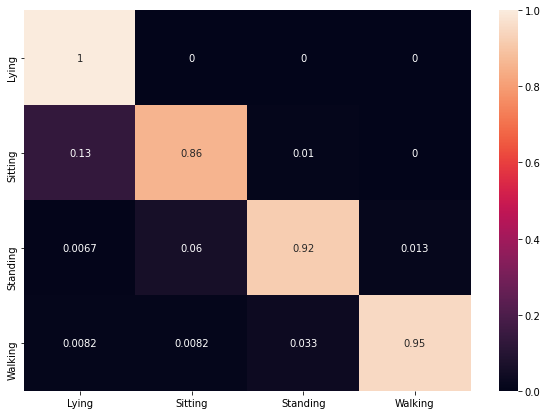

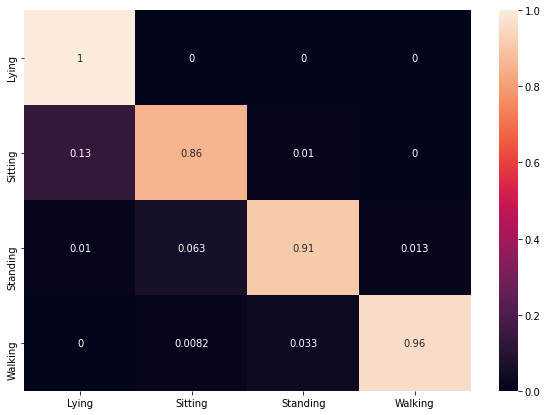

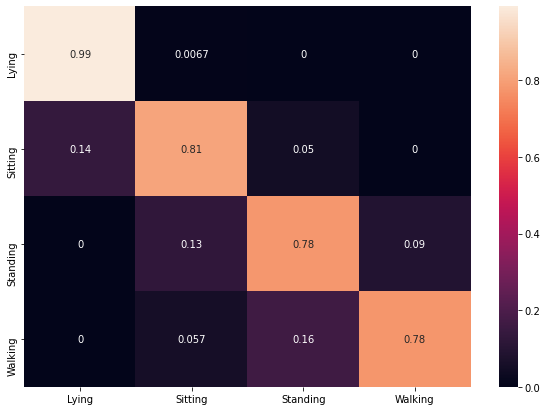

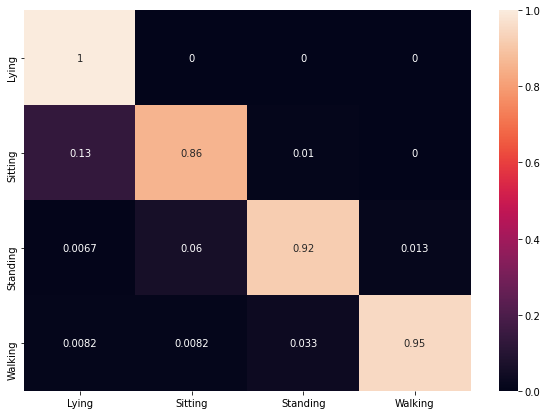

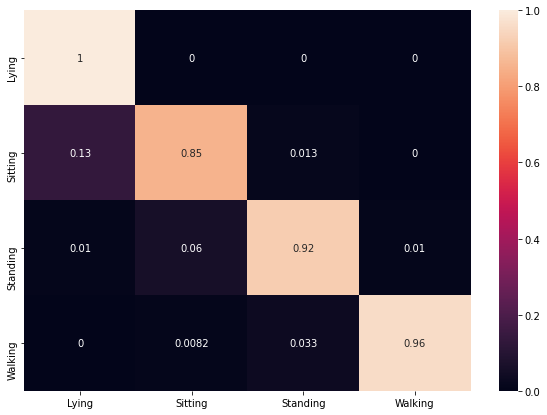

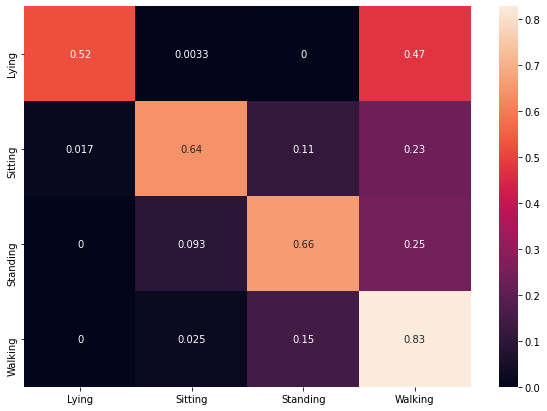

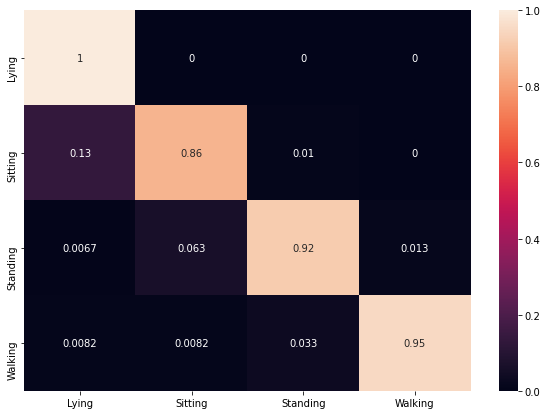

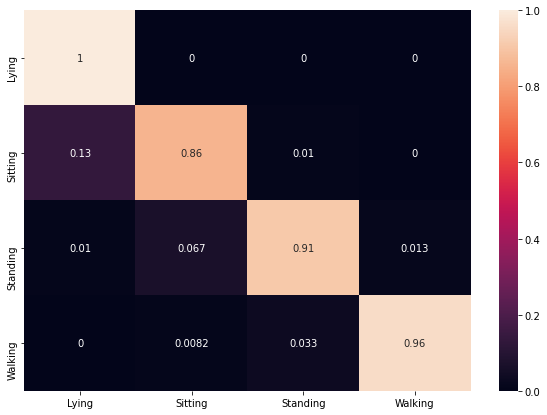

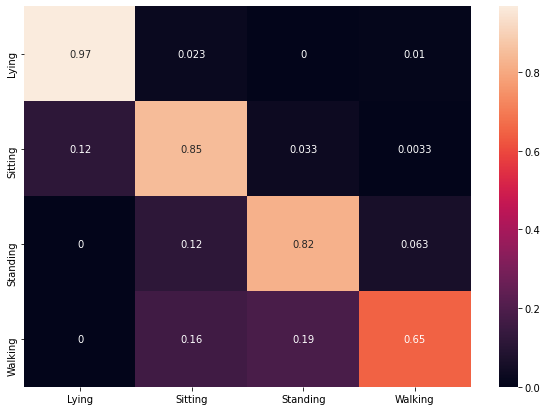

In [ ]:
acc1_,a1_, acc2_ = [],[],[]
model_type = 'attention'

for times in tqdm(range(2,11,2)):
    X_train,y_train,Xval,Xtest,yval,ytest = load_data_num(times)
    # acc1,a1 = evaluate_bmtl(X_train,y_train,Xval,Xtest,yval,ytest)
    acc1,a1 = evaluate_tmtl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc2 = evaluate_stl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc1_.append(acc1)
    a1_.append(a1)
    acc2_.append(acc2)
    # a2_.append(a2)
    # acc3_.append(acc3)
    # i+=3
print("Accuracy of Best Classifiers: Attention Model", a1_)
print("Accuracy of Both Classifiers:Attention Model",acc1_)
# print(a2_)
print("Accuracy of Single Task Model: Attention",acc2_)


  0%|          | 0/5 [00:00<?, ?it/s]

Counter({0.0: 2, 1.0: 2, 2.0: 2, 3.0: 2})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.9090019569471625
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '91.67%' '0.67%']
 ['0.00%' '0.82%' '6.56%' '92.62%']]
              precision    recall  f1-score   support

       Lying       0.88      0.97      0.92       300
     Sitting       0.88      0.84      0.86       300
    Standing       0.94      0.92      0.93       300
     Walking       0.98      0.93      0.95       122

    accuracy                           0.91      1022
   macro avg       0.92      0.91      0.92      1022
weighted avg       0.91      0.91      0.91      1022

Epoch 00201: early stopping
Accuracy score is: 
0.910958904109589
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '92.33%' '0.00%']
 ['0.00%' '0.82%' '6.56%' '92.62%']]
              precision    recall


 20%|██        | 1/5 [04:57<19:48, 297.09s/it]

Run in --- 7.52183985710144 seconds ---
Accuracy score is: 
0.8796477495107632
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['15.00%' '85.00%' '0.00%' '0.00%']
 ['0.00%' '12.00%' '80.00%' '8.00%']
 ['0.00%' '5.74%' '9.02%' '85.25%']]
              precision    recall  f1-score   support

       Lying       0.87      1.00      0.93       300
     Sitting       0.86      0.85      0.85       300
    Standing       0.96      0.80      0.87       300
     Walking       0.81      0.85      0.83       122

    accuracy                           0.88      1022
   macro avg       0.87      0.88      0.87      1022
weighted avg       0.88      0.88      0.88      1022

Counter({0.0: 4, 1.0: 4, 2.0: 4, 3.0: 4})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.9090019569471625
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '90.33%' '2.00%']
 ['0.00%' '0.82%' '3.28%' '95.90%']]
              prec


 40%|████      | 2/5 [10:41<15:33, 311.25s/it]

Run in --- 7.951308012008667 seconds ---
Accuracy score is: 
0.6320939334637965
Confusion Matrix is:
[['76.67%' '19.33%' '0.00%' '4.00%']
 ['18.00%' '67.67%' '6.33%' '8.00%']
 ['0.00%' '10.00%' '34.00%' '56.00%']
 ['0.00%' '2.46%' '6.56%' '90.98%']]
              precision    recall  f1-score   support

       Lying       0.81      0.77      0.79       300
     Sitting       0.69      0.68      0.68       300
    Standing       0.79      0.34      0.48       300
     Walking       0.35      0.91      0.51       122

    accuracy                           0.63      1022
   macro avg       0.66      0.67      0.61      1022
weighted avg       0.71      0.63      0.63      1022

Counter({0.0: 6, 1.0: 6, 2.0: 6, 3.0: 6})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.9090019569471625
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '90.33%' '2.00%']
 ['0.00%' '0.82%' '3.28%' '95.90%']]
              pr


 60%|██████    | 3/5 [17:13<11:10, 335.44s/it]

Run in --- 8.206847190856934 seconds ---
Accuracy score is: 
0.8708414872798435
Confusion Matrix is:
[['100.00%' '0.00%' '0.00%' '0.00%']
 ['17.67%' '80.67%' '0.00%' '1.67%']
 ['0.00%' '13.33%' '82.67%' '4.00%']
 ['0.00%' '11.48%' '6.56%' '81.97%']]
              precision    recall  f1-score   support

       Lying       0.85      1.00      0.92       300
     Sitting       0.82      0.81      0.81       300
    Standing       0.97      0.83      0.89       300
     Walking       0.85      0.82      0.84       122

    accuracy                           0.87      1022
   macro avg       0.87      0.86      0.86      1022
weighted avg       0.88      0.87      0.87      1022

Counter({0.0: 8, 1.0: 8, 2.0: 8, 3.0: 8})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.910958904109589
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '91.00%' '1.33%']
 ['0.00%' '0.82%' '3.28%' '95.90%']]
              pre


 80%|████████  | 4/5 [23:40<05:50, 350.93s/it]

Run in --- 8.241845846176147 seconds ---
Accuracy score is: 
0.7455968688845401
Confusion Matrix is:
[['49.67%' '50.33%' '0.00%' '0.00%']
 ['0.67%' '91.00%' '2.33%' '6.00%']
 ['0.00%' '10.67%' '83.00%' '6.33%']
 ['0.00%' '4.92%' '20.49%' '74.59%']]
              precision    recall  f1-score   support

       Lying       0.99      0.50      0.66       300
     Sitting       0.59      0.91      0.72       300
    Standing       0.89      0.83      0.86       300
     Walking       0.71      0.75      0.73       122

    accuracy                           0.75      1022
   macro avg       0.79      0.75      0.74      1022
weighted avg       0.81      0.75      0.74      1022

Counter({0.0: 10, 1.0: 10, 2.0: 10, 3.0: 10})
Loaded model from disk
Epoch 00201: early stopping
Accuracy score is: 
0.910958904109589
Confusion Matrix is:
[['96.67%' '3.33%' '0.00%' '0.00%']
 ['13.33%' '83.67%' '3.00%' '0.00%']
 ['0.33%' '7.33%' '91.00%' '1.33%']
 ['0.00%' '0.82%' '3.28%' '95.90%']]
              


100%|██████████| 5/5 [29:58<00:00, 359.79s/it]

Run in --- 8.353325128555298 seconds ---
Accuracy score is: 
0.7093933463796478
Confusion Matrix is:
[['50.00%' '50.00%' '0.00%' '0.00%']
 ['2.33%' '81.67%' '13.67%' '2.33%']
 ['0.00%' '10.00%' '78.00%' '12.00%']
 ['0.00%' '4.92%' '16.39%' '78.69%']]
              precision    recall  f1-score   support

       Lying       0.96      0.50      0.66       300
     Sitting       0.57      0.82      0.67       300
    Standing       0.79      0.78      0.79       300
     Walking       0.69      0.79      0.74       122

    accuracy                           0.71      1022
   macro avg       0.75      0.72      0.71      1022
weighted avg       0.76      0.71      0.71      1022

Accuracy of Best Classifiers: Attention Dense Model [0.910958904109589, 0.9099804305283757, 0.910958904109589, 0.9119373776908023, 0.910958904109589]
Accuracy of Both Classifiers:Attention Dense Model [[0.9090019569471625, 0.910958904109589], [0.9090019569471625, 0.9099804305283757], [0.9090019569471625, 0.910958

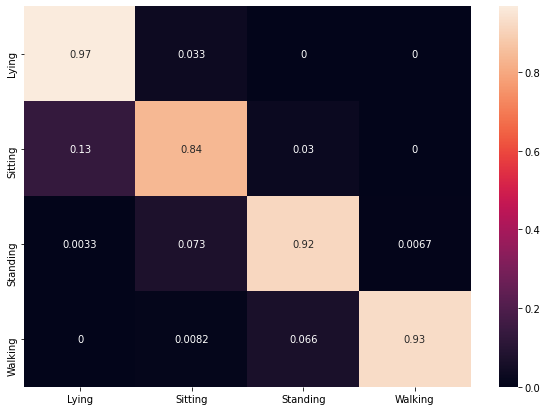

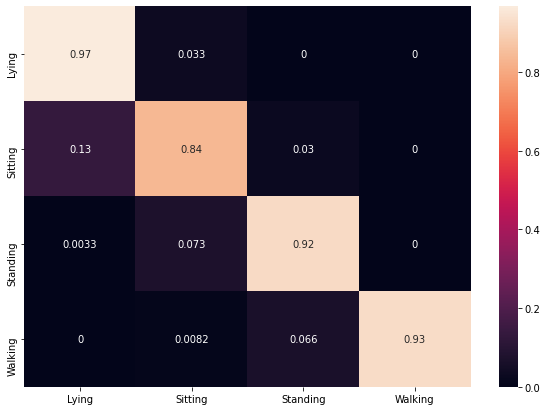

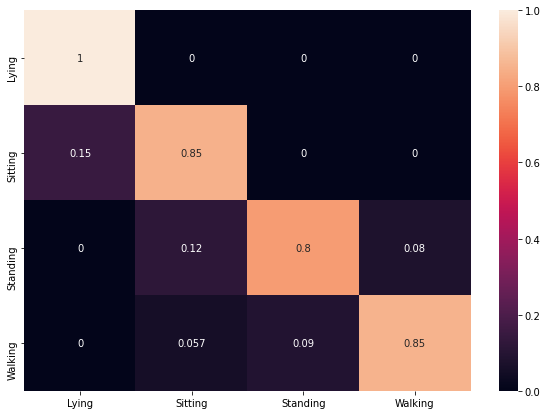

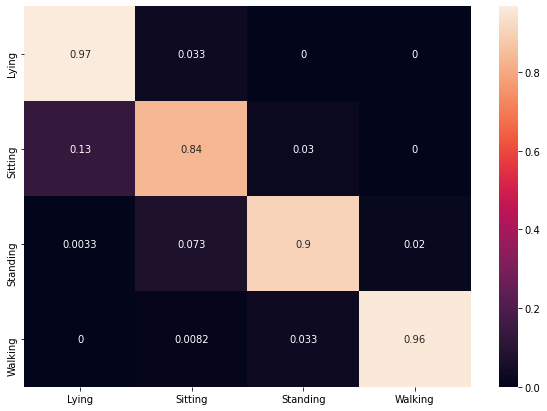

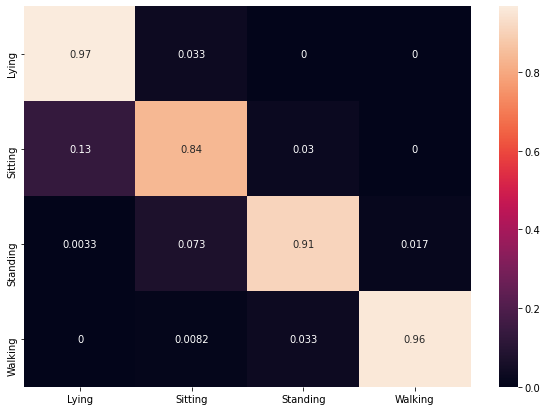

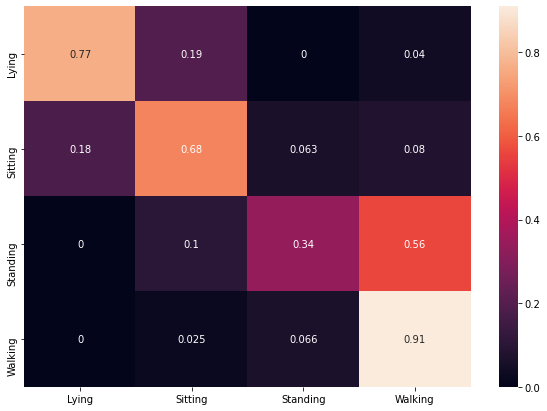

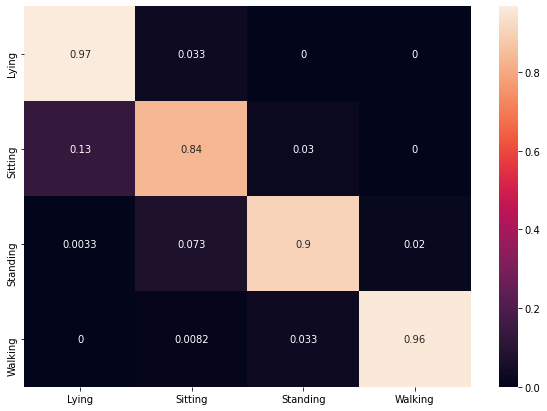

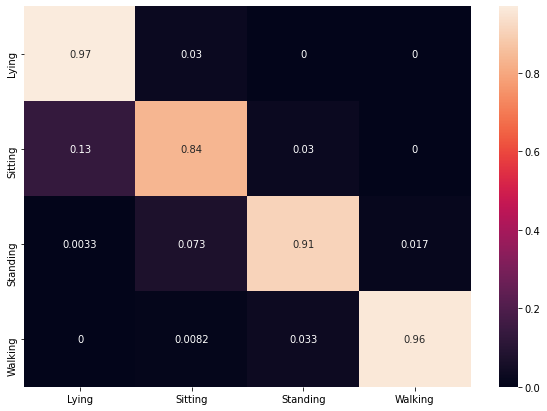

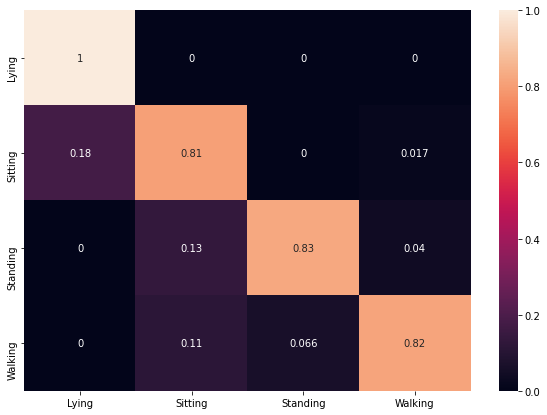

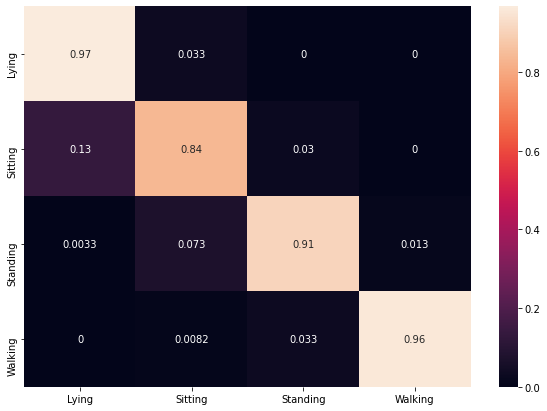

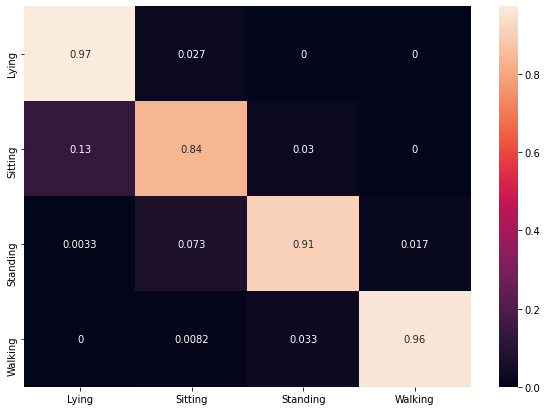

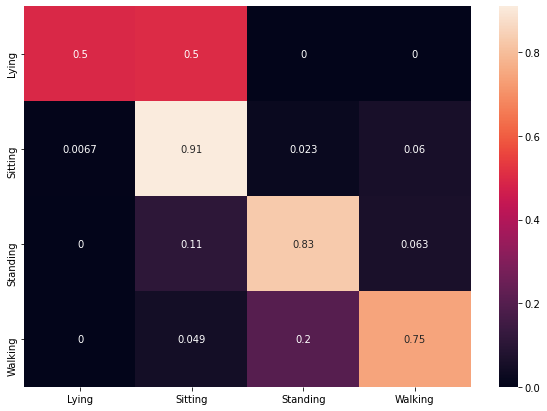

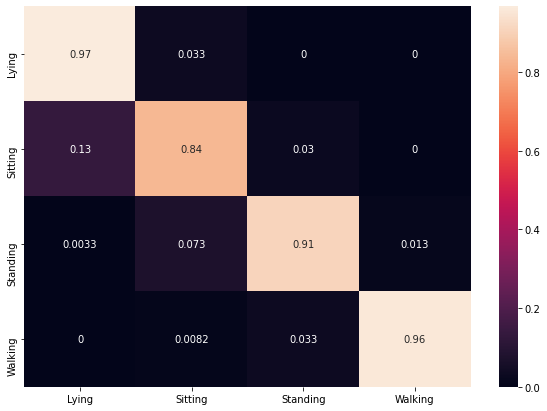

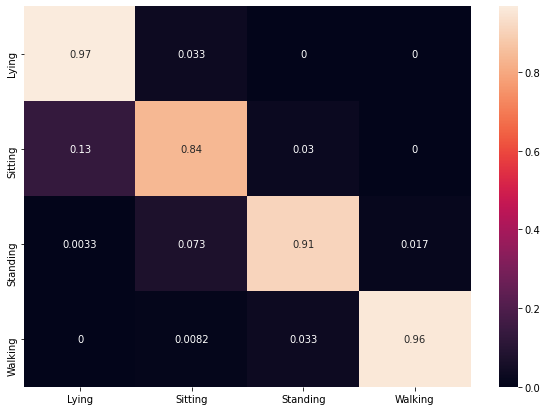

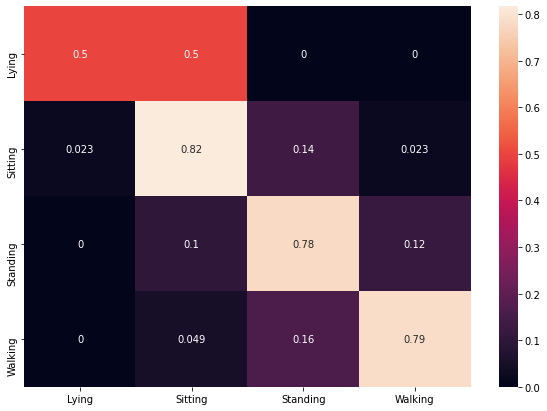

In [ ]:
acc1_,a1_, acc2_ = [],[],[]
model_type = 'attention_dense'

for times in tqdm(range(2,11,2)):
    X_train,y_train,Xval,Xtest,yval,ytest = load_data_num(times)
    # acc1,a1 = evaluate_bmtl(X_train,y_train,Xval,Xtest,yval,ytest)
    acc1,a1 = evaluate_tmtl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc2 = evaluate_stl(X_train,y_train,Xval,Xtest,yval,ytest, model_type)
    acc1_.append(acc1)
    a1_.append(a1)
    acc2_.append(acc2)
    # a2_.append(a2)
    # acc3_.append(acc3)
    # i+=3
print("Accuracy of Best Classifiers: Attention Dense Model", a1_)
print("Accuracy of Both Classifiers:Attention Dense Model",acc1_)
# print(a2_)
print("Accuracy of Single Task Model: Attention Dense",acc2_)